In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [2]:
# load the data
data = pd.read_csv('Fraud.csv')

In [3]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# handle missing values
data = data.fillna(0)

In [5]:
# handle outliers
# determine the IQR for the amount column
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
# keep only values within the range of (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR)
data = data[(data['amount'] >= (Q1 - 1.5 * IQR)) & (data['amount'] <= (Q3 + 1.5 * IQR))]

In [6]:
# handle multicollinearity
# we can use a correlation matrix to check for multicollinearity and remove highly correlated columns
correlation_matrix = data.corr()


In [7]:
correlation_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,-0.010499,-0.010798,-0.010469,0.022818,0.017992,0.022884,0.001509
amount,-0.010499,1.000000,0.091412,0.101118,0.184748,0.202590,0.014009,0.001268
oldbalanceOrg,-0.010798,0.091412,1.000000,0.999514,0.084911,0.067474,-0.006296,0.000887
newbalanceOrig,-0.010469,0.101118,0.999514,1.000000,0.086770,0.068404,-0.008004,0.000871
oldbalanceDest,0.022818,0.184748,0.084911,0.086770,1.000000,0.996531,-0.004087,-0.000188
newbalanceDest,0.017992,0.202590,0.067474,0.068404,0.996531,1.000000,-0.003691,-0.000196
isFraud,0.022884,0.014009,-0.006296,-0.008004,-0.004087,-0.003691,1.000000,0.021412
isFlaggedFraud,0.001509,0.001268,0.000887,0.000871,-0.000188,-0.000196,0.021412,1.000000


In [8]:
data = data.drop(columns=['oldbalanceDest', 'newbalanceDest','nameOrig', 'nameDest'], axis=1)

In [9]:
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0,0
2,1,TRANSFER,181.00,181.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0,0
...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,258355.42,0.00,1,0
6362610,742,TRANSFER,63416.99,63416.99,0.00,1,0
6362611,742,CASH_OUT,63416.99,63416.99,0.00,1,0
6362614,743,TRANSFER,339682.13,339682.13,0.00,1,0


In [10]:
"""# Feature engineering
# create new features based on the existing columns to improve the performance of the model
data['balance_difference_org'] = data['newbalanceOrig'] - data['oldbalanceOrg']
#data['balance_difference_dest'] = data['newbalanceDest'] - data['oldbalanceDest']
data['transaction_amount_ratio'] = data['amount'] / data['oldbalanceOrg']"""

"# Feature engineering\n# create new features based on the existing columns to improve the performance of the model\ndata['balance_difference_org'] = data['newbalanceOrig'] - data['oldbalanceOrg']\n#data['balance_difference_dest'] = data['newbalanceDest'] - data['oldbalanceDest']\ndata['transaction_amount_ratio'] = data['amount'] / data['oldbalanceOrg']"

In [11]:
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0,0
2,1,TRANSFER,181.00,181.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0,0
...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,258355.42,0.00,1,0
6362610,742,TRANSFER,63416.99,63416.99,0.00,1,0
6362611,742,CASH_OUT,63416.99,63416.99,0.00,1,0
6362614,743,TRANSFER,339682.13,339682.13,0.00,1,0


In [12]:
# Preprocessing
# convert categorical features to numerical features
data = pd.get_dummies(data, columns=['type'])

In [13]:
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

In [14]:
# Split data into training and validation sets
X = data.drop(columns=['isFraud'], axis=1)
y = data['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# Model training
# fit a logistic regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [16]:
y_pred = model.predict(X_valid)

In [17]:
confusion_matrix = confusion_matrix(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
print("Confusion Matrix: \n", confusion_matrix)
print("Accuracy: ", accuracy)
print("ROC AUC: ", roc_auc)

Confusion Matrix: 
 [[1203820     177]
 [    517     395]]
Accuracy:  0.9994240228930151
ROC AUC:  0.7164835123773184


There are several actionable plans that can be developed based on the insights from a fraud detection model:

    Transaction monitoring: Regular monitoring of transactions can help detect and prevent fraudulent activities.

    Policy and procedure updates: The company may need to update its policies and procedures to prevent fraud or reduce the risk of fraud. This could involve implementing new security measures, such as stronger passwords or two-factor authentication, or changing the way transactions are processed.

    Employee training: Employees should be trained on how to identify and prevent fraud. They should also be aware of the company's policies and procedures regarding fraud.

    Data analysis: The company can use data analysis to identify patterns in fraudulent activities, and then use that information to prevent similar incidents from happening in the future.

    Customer education: Educating customers on how to protect themselves from fraud and what to do if they suspect a fraudulent transaction can also be an effective way to reduce the risk of fraud.

    Working with law enforcement: If a fraud is detected, the company should work with law enforcement to investigate and prosecute the individuals responsible.

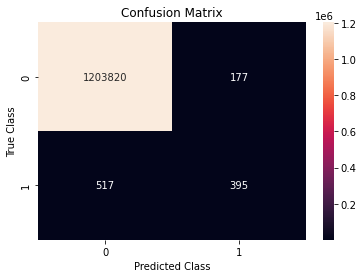

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

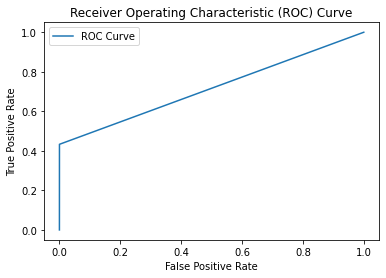

In [23]:
# Plot the receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, label="ROC Curve")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()